# **MNIST Classification example**
### Resume
Example using the MNIST database

## References
https://www.tensorflow.org/quantum/tutorials/mnist




---

## Installation

In [ ]:
%%capture
!pip install -q tensorflow==2.5.1
!pip install -q -U tensorflow-quantum
!pip install -q -U tfq-nightly
import importlib, pkg_resources
importlib.reload(pkg_resources)

In [ ]:
# !pip show tensorflow
# !pip show tensorflow-quantum
# !pip show tfq-nightly

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import collections
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit



---

## Load the data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
# Lets just keep the classes 3 and 6, and remove the rest to keep it simple.
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


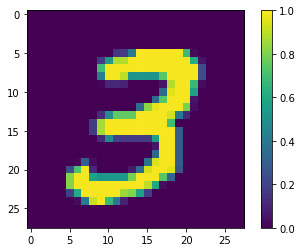

In [ ]:
# Show the first case
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### Downscale the images

In [ ]:
# From 28x28 to 4x4.
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


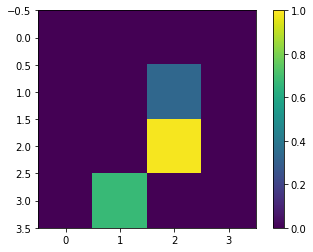

In [ ]:
# Show the first case again
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### Remove contradictory examples

In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### Encode the data as quantum a quantum circuit

True


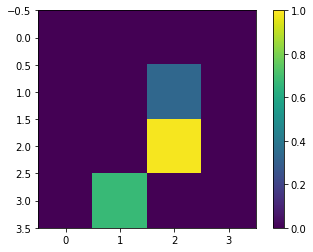

In [ ]:
print(y_train_nocon[0])

plt.imshow(x_train_nocon[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# We will make it binary
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

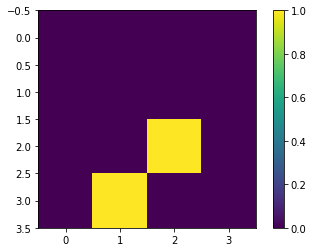

In [ ]:
plt.imshow(x_train_bin[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# We remove the contradictions before because otherwise there will be just 193
# images available.
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


In [ ]:
# To convert the image into a circuit we will check the values. If it is a '1'
# we apply a X
def convert_to_circuit(image):
    # Encode truncated classical image into quantum datapoint.
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


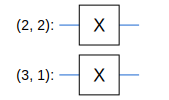

In [ ]:
# There should be X just where there are '1's.
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [ ]:
# Finally convert to tensor 
x_train_tfcirc = tfq.convert_to_tensor(x_data_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

NameError: ignored

## Quantum neural network

### Build the model circuit

In [ ]:
# Lets create a class that contains the qubits and layers.
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

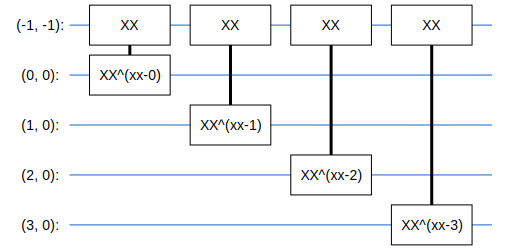

In [ ]:
#    --------               -------------
#  --|  XX  |---          --|           |--
#    --------               |           |
#        |            =     |   Rxx(t)  |
#    --------               |           |
#  --|XX^(xx)|---         --|           |--
#    --------               -------------


demo_builder = CircuitLayerBuilder(
    data_qubits = cirq.GridQubit.rect(4,1),
    readout = cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

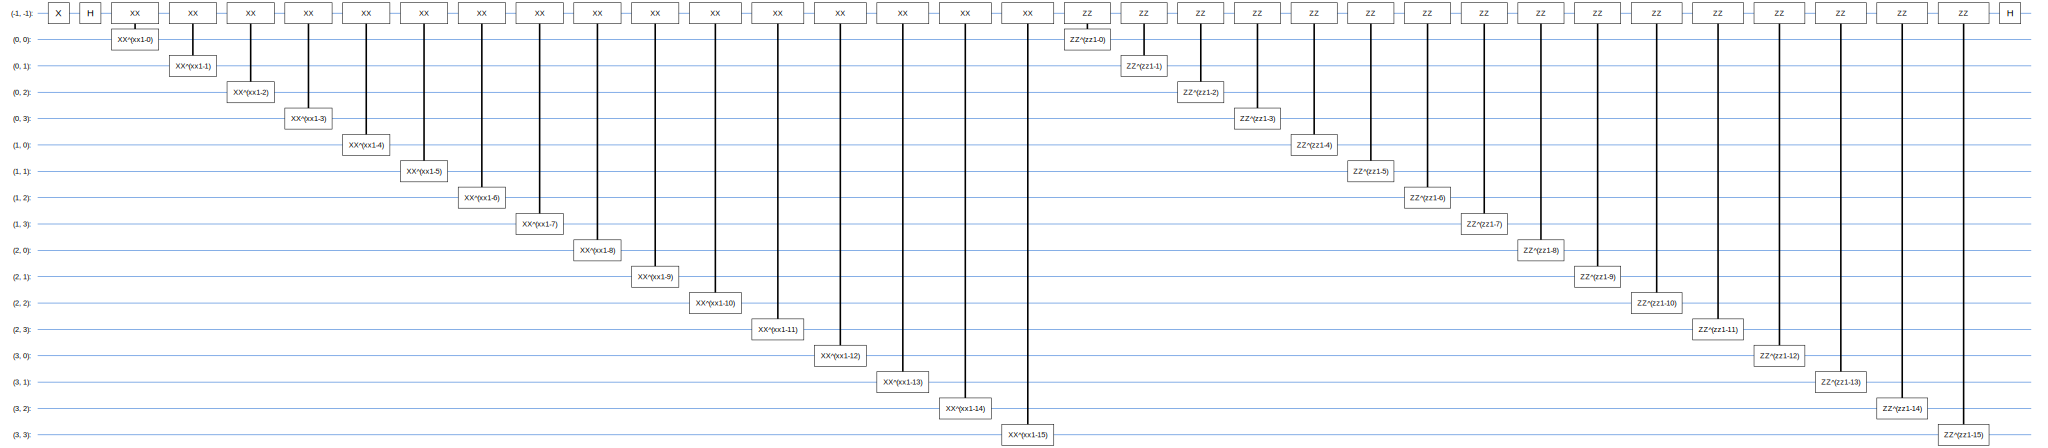

In [ ]:
model_circuit, model_readout = create_quantum_model()
SVGCircuit(model_circuit)

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
# 32 params as we have a RXX and a RZZ for each qubit (16).
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 704s 2s/step - loss: 0.6570 - hinge_accuracy: 0.7766 - val_loss: 0.4099 - val_hinge_accuracy: 0.8579
Epoch 2/3
324/324 [==============================] - 702s 2s/step - loss: 0.3919 - hinge_accuracy: 0.8648 - val_loss: 0.3699 - val_hinge_accuracy: 0.8977
Epoch 3/3
62/62 [==============================] - 27s 433ms/step - loss: 0.3594 - hinge_accuracy: 0.8997
